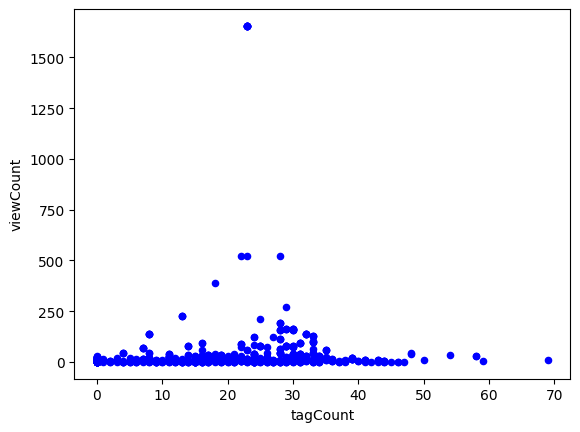

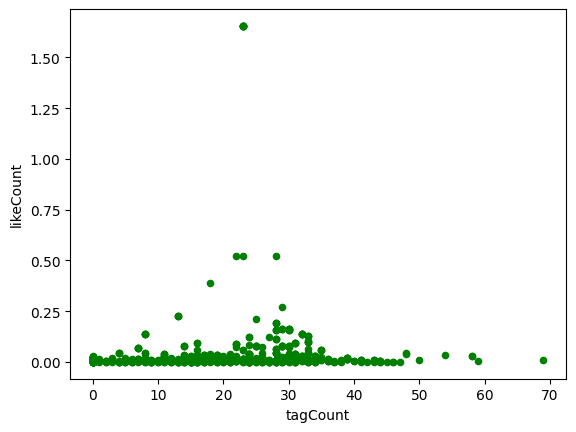

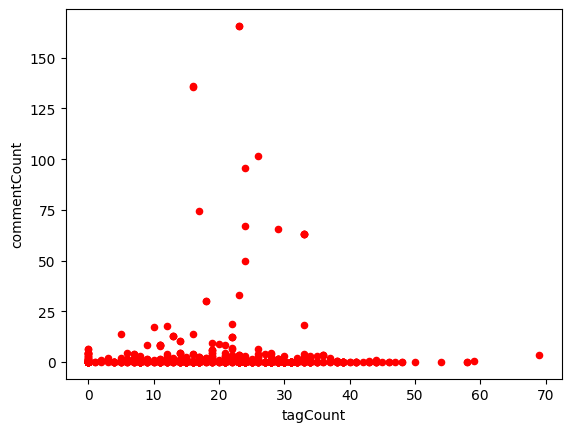

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb

df = pd.read_csv("base_dataset.csv")
df = df[df['viewCount'].notna()]
df = df[df['likeCount'].notna()]
df = df[df['commentCount'].notna()]

df["viewCount"] = df["viewCount"] / 10**6
df["likeCount"] = df["viewCount"] / 10**3
df["commentCount"] = df["commentCount"] / 10**3

df["tagCount"] = df.loc[:,"tags"].apply(lambda x: 0 if pd.isna(x) else len(x.split(",")))
df.plot.scatter(x="tagCount", y="viewCount", c="blue")
df.plot.scatter(x="tagCount", y="likeCount", c="green")
df.plot.scatter(x="tagCount", y="commentCount", c="red")


x_labels = ["tagCount"]
y_labels = ["viewCount", "likeCount", "commentCount"]
x = df.loc[:, x_labels]
y = df.loc[:, y_labels]
dmatrix = xgb.DMatrix(data=x,label=y)

RMSE: 124.16136794035953


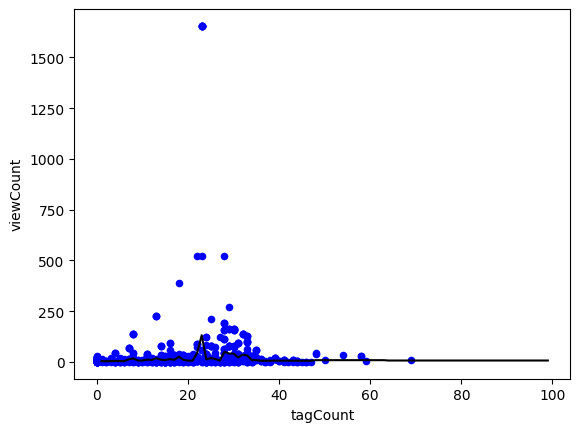

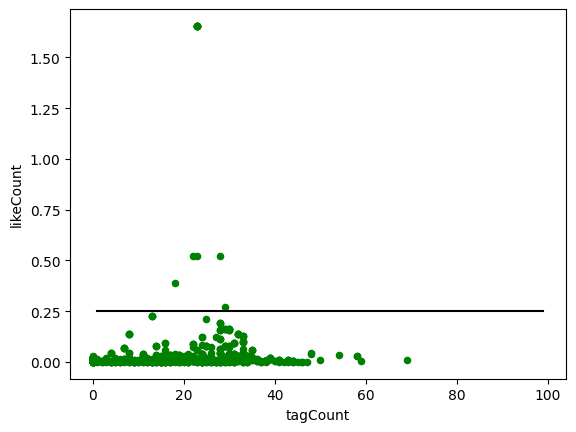

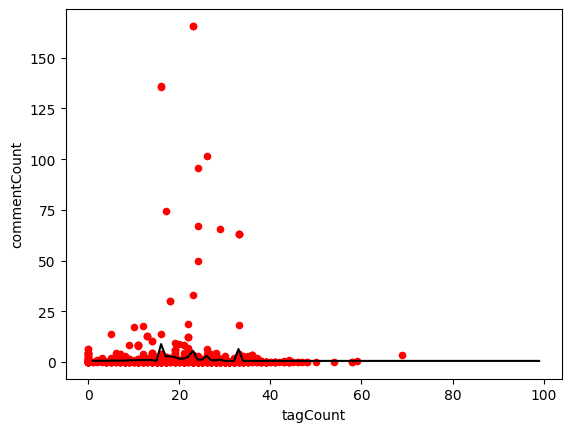

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror',
                           colsample_bytree = 0.3, 
                           learning_rate = 0.1,
                           max_depth = 10, 
                           alpha = 50, 
                           n_estimators = 10)

xgb_reg.fit(x_train, y_train)
pred = xgb_reg.predict(x_test)

test_values = pd.DataFrame({"tagCount": range(1,100)})

df.plot.scatter(x="tagCount", y="viewCount", c="blue")
plt.plot(test_values, xgb_reg.predict(test_values)[:,0], c="black")
df.plot.scatter(x="tagCount", y="likeCount", c="green")
plt.plot(test_values, xgb_reg.predict(test_values)[:,1], c="black")
df.plot.scatter(x="tagCount", y="commentCount", c="red")
plt.plot(test_values, xgb_reg.predict(test_values)[:,2], c="black")


print("RMSE: " + str(np.sqrt(mean_squared_error(y_test, pred))))

In [7]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.3,
                'max_depth': 10, 'alpha': 10}

cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3,
                    num_boost_round=100,early_stopping_rounds=20,metrics="rmse", as_pandas=True, seed=123)

cv_results.describe()
print(cv_results)

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0        91.090988        3.732703       91.093904       8.681391
1        88.495440        3.338890       88.832230       8.356700
2        87.147969        3.127699       87.795114       7.890722
3        86.452434        3.021541       87.354288       7.429542
4        86.097054        2.965904       87.193656       7.037225
5        85.914080        2.936251       87.152253       6.720735
